# IMDb with HaGraD, backed by  <img src="https://upload.wikimedia.org/wikipedia/commons/1/10/PyTorch_logo_icon.svg" style="height:0.75em"/>PyTorch

---

Guidance by this [notebook from pytorch.org](https://pytorch.org/tutorials/beginner/text_sentiment_ngrams_tutorial.html).

### Setup

In [1]:
## Stuff from torch
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader
from torch.hub import load_state_dict_from_url

## Stuff from torchtext
import torchtext as tt
from torchtext.datasets import IMDB
from torchtext.data import get_tokenizer
from torchtext.data.functional import to_map_style_dataset # Enable proper shuffeling
import torchtext.functional as ttF
import torchtext.vocab as ttv

## Misc
import numpy as np
import string
from nltk.corpus import stopwords

## Additional stuff
import matplotlib.pyplot as plt
import sys
if "..\\" not in sys.path: sys.path.append("..\\")
from src.torch_hagrad import Hagrad

In [2]:
## Setting
vocab_size = 1000
batch_size = 128
epochs = 10

In [3]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device.")

Using cuda device.


---

### Data Preprocessing

In [4]:
## The usage of `to_map_style_dataset` is important to enable proper shuffeling
#  when constructing the DataLoaders
trn_rawpipe = to_map_style_dataset(
    IMDB("C:/Users/janni/.torchtext/cache", split="train"))
tst_rawpipe = to_map_style_dataset(
    IMDB("C:/Users/janni/.torchtext/cache", split= "test"))
tokenizer = get_tokenizer("basic_english")
stopwords = stopwords.words('english')

In [5]:
## Constructing Vocab (using train data)
#  Saving time when rerunning the notebook...
def yield_tokens(text_datapipe):
    for x in text_datapipe:
        text = "".join([char for char in x[1] if char not in string.punctuation])
        text = tokenizer(text)
        text = [word for word in text if word not in stopwords]
        yield text

if 'vocab' not in locals():
    vocab = ttv.build_vocab_from_iterator(
        yield_tokens(trn_rawpipe), specials=["<pad>", "<unk>"], max_tokens=vocab_size)
    vocab.set_default_index(vocab(["<unk>"])[0])

### Finalize <span style="color:#4bc9b0;font-family:'CaskaydiaCove NF', 'Cascadia Code', Consolas, monospace">DataLoaders</span>

In [8]:
## Defining preprocessing routines
padding_idx = vocab(["<pad>"])[0]

def text_pipeline(text): 
    text = "".join([char for char in text if char not in string.punctuation])
    text = tokenizer(text)
    text = [word for word in text if word not in stopwords]
    tokens = vocab(text)
    tokens = [t for t in tokens if t!=1] # Omitting unkown tokens
    return tokens

def pad_from_left(text_list):
    max_len = np.max([len(r) for r in text_list])
    padded_texts = np.zeros((len(text_list), max_len), dtype=int)
    for i, text in enumerate(text_list):
        if len(text) != 0:
            padded_texts[i, -len(text):] = np.array(text)[:max_len]
    return padded_texts


def collate_batch(batch):
    label_list, text_list = [], []
    for _label, _text in batch:
        label_list.append(_label - 1)
        processed_text = text_pipeline(_text)
        text_list.append(processed_text)

    text_list = torch.tensor(pad_from_left(text_list), dtype=torch.int64).to(device)
    label_list = torch.tensor(label_list, dtype=torch.float32).to(device)
    return text_list, label_list

In [9]:
trn_dataloader = DataLoader(trn_rawpipe, 
                            batch_size=batch_size,
                            shuffle=True, collate_fn=collate_batch)
tst_dataloader = DataLoader(tst_rawpipe,
                            batch_size=batch_size,
                            shuffle=True, collate_fn=collate_batch)

___

### Define Model

In [138]:
vocab_size = len(vocab) + 1
embedding_size = 64
rnn_hidden_size = 64
rnn_layers = 1
linear_size = 64

In [139]:
class BidirRNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding  = nn.Embedding(vocab_size, embedding_size, 
                                       padding_idx=padding_idx
                                       )
        self.rnn        = nn.LSTM(embedding_size, rnn_hidden_size, 
                                  num_layers=rnn_layers, batch_first=True, 
                                  bidirectional=True)
        self.dense      = nn.Sequential(
            nn.Linear(2*rnn_hidden_size, linear_size),
            nn.ReLU())
        self.out        = nn.Linear(linear_size, 1)

    def forward(self, x):
        x = self.embedding(x.long())
        rnn_out, rnn_hidden = self.rnn(x)
        x = self.dense(rnn_out[:, -1, :])
        x = self.out(x).flatten()
        return x

In [140]:
## Store 1 state dict to initial parameters can be identical for every new 
#  instance:
init_model = BidirRNN().to(device)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def get_model():
    model = BidirRNN().to(device) # BidirRNN
    model.load_state_dict(init_model.state_dict())
    return model

print(f"The model has {count_parameters(init_model):,} trainable parameters")

The model has 138,945 trainable parameters


In [141]:
from torchinfo import summary
summary(init_model, input_size=(batch_size, 99))

Layer (type:depth-idx)                   Output Shape              Param #
BidirRNN                                 [128]                     --
├─Embedding: 1-1                         [128, 99, 64]             64,064
├─LSTM: 1-2                              [128, 99, 128]            66,560
├─Sequential: 1-3                        [128, 64]                 --
│    └─Linear: 2-1                       [128, 64]                 8,256
│    └─ReLU: 2-2                         [128, 64]                 --
├─Linear: 1-4                            [128, 1]                  65
Total params: 138,945
Trainable params: 138,945
Non-trainable params: 0
Total mult-adds (M): 852.71
Input size (MB): 0.05
Forward/backward pass size (MB): 19.53
Params size (MB): 0.56
Estimated Total Size (MB): 20.14

### "Testing" the Model

In [142]:
criterion = nn.BCEWithLogitsLoss()

In [143]:
## Testing one forward pass
test_datum = next(iter(trn_dataloader))
texts_   = test_datum[0]
labels_  = test_datum[1]
print( f"Texts shape: {  texts_.shape}")
print(f"Labels shape: { labels_.shape}")

Texts shape: torch.Size([128, 281])
Labels shape: torch.Size([128])


In [144]:
preds_ = init_model(texts_)
print(f"Output shape: {preds_.shape}")
print(f"Loss: {criterion(preds_, labels_):.2f}")

Output shape: torch.Size([128])
Loss: 0.71


### Acutal Training:

In [145]:
def binary_accuracy(preds, y):
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float()
    return correct.sum()

def train_loop(epochs: int, optimizer: torch.optim.Optimizer, model: nn.Module):

    def train_step(input, target):
        model.zero_grad()
        output = model(input)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        return loss.detach().cpu().numpy(), binary_accuracy(output, target)/batch_size

    def eval_step(input, target):
        output = model(input)
        loss = criterion(output, target).item()
        return float(loss), binary_accuracy(output, target)

    def evaluate():
        model.eval()
        total_loss = 0
        correct_predictions = 0
        total_predictions = 0
        with torch.no_grad():
            for k, (text, label) in enumerate(tst_dataloader):
                loss, predictions = eval_step(text, label)
                total_loss += loss
                correct_predictions += predictions
                total_predictions += len(label)

        return total_loss / k, correct_predictions / total_predictions

    history = {
        'batch_loss': [],
        'loss': [],
        'val_loss': []}

    for e in range(epochs):
        total_loss = 0
        model.train()
        for i, (text, label) in enumerate(trn_dataloader):
            batch_loss, batch_accuracy = train_step(text, label)
            history['batch_loss'].append(batch_loss)
            print(f"Batch = [{i}], loss = [{batch_loss:.2f}], acc = [{batch_accuracy:.2f}]", end="\r")
            total_loss += batch_loss
        val_loss, val_accuracy = evaluate()
        print(f"Epoch = [{e+1}], loss = [{val_loss:.2f}], acc = [{val_accuracy:.2f}]" + 4*" ")
        history['val_loss'].append(val_loss)
        history['loss'].append(total_loss / i)

    return history

Executing the train loops:

In [146]:
model = get_model()
optimizer = torch.optim.Adam(model.parameters(), 0.001)
adam_history = train_loop(epochs, optimizer, model)

Epoch = [1], loss = [0.50], acc = [0.77]    
Epoch = [2], loss = [0.39], acc = [0.83]    
Epoch = [3], loss = [0.36], acc = [0.84]    
Epoch = [4], loss = [0.38], acc = [0.84]    
Epoch = [5], loss = [0.35], acc = [0.85]    
Epoch = [6], loss = [0.35], acc = [0.85]    
Epoch = [7], loss = [0.37], acc = [0.85]    
Epoch = [8], loss = [0.37], acc = [0.85]    
Epoch = [9], loss = [0.40], acc = [0.84]    
Epoch = [10], loss = [0.40], acc = [0.84]    


In [147]:
model = get_model()
optimizer = Hagrad(model.parameters(), epsilon=10., gamma=20., p_mean=0.)
hagrad_history = train_loop(epochs, optimizer, model)

Epoch = [1], loss = [0.68], acc = [0.57]    
Epoch = [2], loss = [0.62], acc = [0.65]    
Epoch = [3], loss = [0.59], acc = [0.70]    
Epoch = [4], loss = [0.49], acc = [0.77]    
Epoch = [5], loss = [0.50], acc = [0.76]    
Epoch = [6], loss = [0.80], acc = [0.63]    
Epoch = [7], loss = [0.54], acc = [0.73]    
Epoch = [8], loss = [0.57], acc = [0.73]    
Epoch = [9], loss = [0.42], acc = [0.82]    
Epoch = [10], loss = [0.43], acc = [0.81]    


### Evaluate Fit

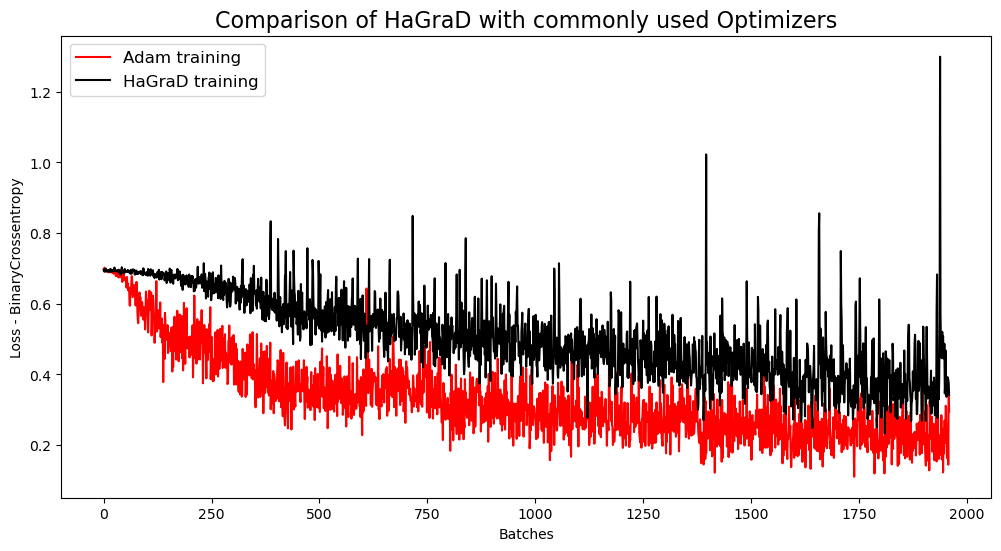

In [148]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_title("Comparison of HaGraD with commonly used Optimizers", fontsize=16)
ax.plot(  adam_history['batch_loss'], "r-",  label=  "Adam training") 
ax.plot(hagrad_history['batch_loss'], "k-",  label="HaGraD training") 
ax.set_xlabel("Batches")
ax.set_ylabel("Loss - BinaryCrossentropy")
leg = ax.legend(frameon=True, fontsize=12)
plt.show()
plt.close()

In [149]:
epochs_arr = np.arange(epochs)
epochs_arr_val = epochs_arr + 1

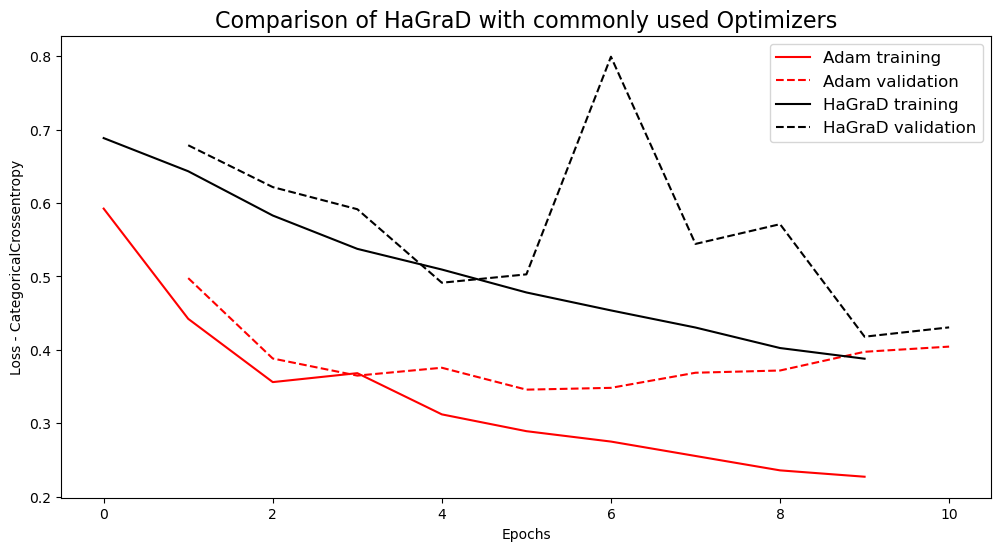

In [150]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_title("Comparison of HaGraD with commonly used Optimizers", fontsize=16)
ax.plot(epochs_arr,           adam_history['loss'], "r-",  label=  "Adam training") 
ax.plot(epochs_arr_val,   adam_history['val_loss'], "r--", label=  "Adam validation") 
ax.plot(epochs_arr,         hagrad_history['loss'], "k-",  label="HaGraD training") 
ax.plot(epochs_arr_val, hagrad_history['val_loss'], "k--", label="HaGraD validation") 
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss - CategoricalCrossentropy")
leg = ax.legend(frameon=True, fontsize=12)
plt.show()
plt.close()